In [1]:
# Install the required libraries such as transformers, datasets, torch, tensorflow
!pip install transformers datasets
!pip install transformers[torch] accelerate -U

  Using cached accelerate-0.29.3-py3-none-any.whl (297 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 k

In [2]:
import os

# set the CUDA_VISIBLE_DEVICES to run the program entirely on the CPU and disbale the GPU usage
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [20]:
# import the necessary libraries
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from google.colab import drive



In [6]:
# load the dataset from the hugging face dataset library
app_dataset = load_dataset("app_reviews")
app_dataset


# mount the google drive to access the file
# Im using the drive to store the output and save the model into the google drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/288065 [00:00<?, ? examples/s]

Mounted at /content/drive


In [7]:
# check the columns of the data
data_columns = app_dataset["train"].features
data_columns

{'package_name': Value(dtype='string', id=None),
 'review': Value(dtype='string', id=None),
 'date': Value(dtype='string', id=None),
 'star': Value(dtype='int8', id=None)}

In [8]:
# printing the first row from the dataset to check the columns and data
data = app_dataset['train'][:1]
data

{'package_name': ['com.mantz_it.rfanalyzer'],
 'review': ["Great app! The new version now works on my Bravia Android TV which is great as it's right by my rooftop aerial cable. The scan feature would be useful...any ETA on when this will be available? Also the option to import a list of bookmarks e.g. from a simple properties file would be useful."],
 'date': ['October 12 2016'],
 'star': [4]}

In [11]:
# From the dataset, I have chosen the two columns i.e is review and star.
# Also I have taken only few rows from the dataset , as training time is taking very long
app_reviews = app_dataset["train"]["review"][:250] # Review is the subset of the review text
app_ratings = app_dataset["train"]["star"][:250]  # star is the ratings given by the customers
print("review total len: ",len(app_reviews))
print("rating total len: ",len(app_ratings))

review total len:  250
rating total len:  250


In [15]:
def check_null_values(app_column):
  '''
  defined a function to check the null values in dataset
  parameters: column name
  return: sum of null values found
  '''
  get_null_values = sum(1 for text in app_column if text is None)
  return get_null_values

# get the nul values from above function
count_review_null = check_null_values(app_reviews)
count_rating_null = check_null_values(app_ratings)

# print the null values for columns
print("total null values found for review: ",count_review_null)
print("total null values found for rating: ",count_rating_null)


total null values found for review:  0
total null values found for rating:  0


In [18]:
# Covert the app_reviews and app_ratings into pandas Dataframe
df = pd.DataFrame({'review': app_reviews, 'rating': app_ratings})

# convert the app_review dataframe into list
app_reviews = df["review"].tolist()
app_ratings = df["rating"]

# print the first five rows from the dataframe
df.head()

,review,rating
0,Great app! The new version now works on my Bra...,4
1,Great It's not fully optimised and has some is...,4
2,Works on a Nexus 6p I'm still messing around w...,5
3,The bandwidth seemed to be limited to maximum ...,3
4,Works well with my Hackrf Hopefully new update...,5


In [19]:
# load the Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load DistilBERT tokenizer and model
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
# Now split the dataset into training, testing and validation sets
train_app_reviews, test_app_reviews, train_app_ratings, test_app_ratings = train_test_split(app_reviews, app_ratings, test_size=0.2, random_state=42)
train_app_reviews, val_app_reviews, train_app_ratings, val_app_ratings = train_test_split(train_app_reviews, train_app_ratings, test_size=0.2, random_state=42)

# Assign the maximum length for the truncation
max_length = 512

In [23]:
# Toeknize and encode the training, testing and validation app_reviews
encoded_train_app_reviews = tokenizer(train_app_reviews, padding=True, truncation=True, return_tensors='pt')
encoded_test_app_reviews = tokenizer(test_app_reviews, padding=True, truncation=True, return_tensors='pt')
encoded_val_app_reviews = tokenizer(val_app_reviews, padding=True, truncation=True, return_tensors='pt')


In [24]:
# get the input_ids, attention_mask for the trianing data
get_train_input_ids = encoded_train_app_reviews['input_ids']
get_train_attention_mask = encoded_train_app_reviews['attention_mask']

# get the input_ids, attention_mask for the testing data
get_test_input_ids = encoded_test_app_reviews['input_ids']
get_test_attention_mask = encoded_test_app_reviews['attention_mask']

# get the input_ids, attention_mask for the validation data
get_val_input_ids = encoded_val_app_reviews['input_ids']
get_val_attention_mask = encoded_val_app_reviews['attention_mask']

In [44]:
# Define a class called load_custom_dataset for tokenizations and label conversion
class load_custom_dataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx], 'labels': self.labels[idx]}



In [45]:
# Here convert the ratings form numbers to binary format [0,1]
def convert_binary_rating(ratings):
  '''
  defined a function to convert the number to binary format [0,1]
  parameters: ratings or star
  return: binary values[0,1]
  '''
  get_binary_ratings = [1 if rating >= 3 else 0 for rating in ratings]
  return get_binary_ratings


In [46]:
# conver the rating numbers to binary format (0,1)
binary_rating_train = convert_binary_rating(train_app_ratings)
binary_rating_test = convert_binary_rating(test_app_ratings)
binary_rating_val = convert_binary_rating(val_app_ratings)

In [47]:
training_data = load_custom_dataset(get_train_input_ids, binary_rating_train)
testing_data = load_custom_dataset(get_test_input_ids, binary_rating_test)
validating_data = load_custom_dataset(get_val_input_ids, binary_rating_val)

In [48]:
train_argumnets = TrainingArguments(
    output_dir='/content/drive/MyDrive/training_results',           # Output directory saved into the google drive
    num_train_epochs=5,                                    # Assign the total number of training epochs
    per_device_train_batch_size=8,                         # Assign the training batch size per device
    per_device_eval_batch_size=8,                          # Assign the validation batch size per device
    warmup_steps=500,                                      # Assign the no of warmup steps for the learning rate
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/training_logs',    # save the logs into google drive
    logging_steps=10,                                      # Give the logg steps to check the training during epochs
    evaluation_strategy='epoch',                           # Evaluate the strategies at end of each epoch
)

In [49]:
# Load the BertForSequenceClassification for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:

# Call or Define the Trainer with model, training-arguments, training-dataset and validation dataset
model_training = Trainer(
    model=model,
    args=train_argumnets,
    train_dataset=training_data,
    eval_dataset=validating_data,  # You can use a separate eval dataset if available
)

In [52]:
# Train the model and check the model performance
model_result = model_training.train()

Epoch,Training Loss,Validation Loss
1,0.516900,0.363600
2,0.456000,0.356084
3,0.467800,0.373722
4,0.598300,0.382826
5,0.485300,0.339624


In [61]:

show_train_losses = [0.51690, 0.456000, 0.467800, 0.598300, 0.485300]
show_val_losses = [0.363600, 0.356084, 0.373722, 0.382826, 0.339624]

# printing the model result
model_result

TrainOutput(global_step=100, training_loss=0.4899401521682739, metrics={'train_runtime': 1517.651, 'train_samples_per_second': 0.527, 'train_steps_per_second': 0.066, 'total_flos': 67981318928640.0, 'train_loss': 0.4899401521682739, 'epoch': 5.0})

In [54]:
# Evaluate the model on Testing dataset
test_data_result = model_training.evaluate(eval_dataset=testing_data)

In [55]:
test_data_result

{'eval_loss': 0.445894330739975,
 'eval_runtime': 70.0402,
 'eval_samples_per_second': 0.714,
 'eval_steps_per_second': 0.1,
 'epoch': 5.0}

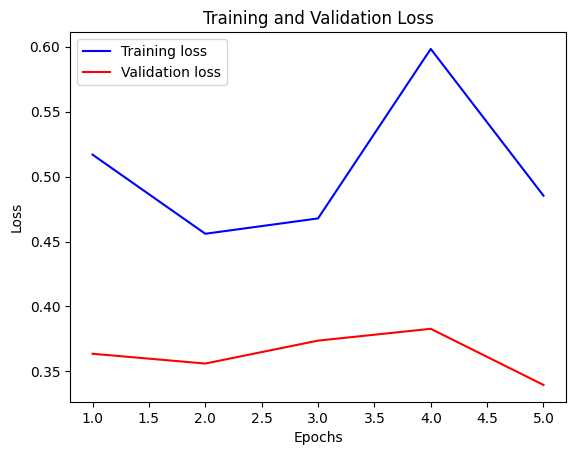

In [62]:
# plot the training and validation loss
import matplotlib.pyplot as plt

# set the number of epochs
epochs = range(1, len(train_losses) + 1)

# Plot the graph
plt.plot(epochs, show_train_losses, 'b', label='Training loss')
plt.plot(epochs, show_val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
